<a href="https://colab.research.google.com/github/alim98/Fusion-Project/blob/main/DF_FINAL_JUST_rx50_plus_attention_Added_MCF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Model saved states are available in mikaeili.barzili colab

In [1]:
!pip install albumentations==0.4.6


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.2/117.2 kB 2.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for albumentations: filename=albumentations-0.4.6-py3-none-any.whl size=65153 sha256=6a7786a318e2031b70d42871bb2c9ddd7a1e03c74cf7615ede7716835cf2e2a0
  Stored in directory: /root/.cache/pip/wheels/f9/d7/0c/6ed42fd872f7d1af78b25045f8b16be330f2c70ae72c83e37d
Successfully built albumentations
  Attempting uninstall: albumentations
    Found existing installation: albumentations 1.3.1
    Uninstalling albumentations-1.3.1:
      Successfully uninstalled albumentations-1.3.1


# Image segmentation using Vanilla UNet, UNet with ResNeXt50 backbone, and Feature Pyramid Network.

**Steps**:
+ **Data Preparation**

+ **Data Visualization**

+ **Data Augmentaions**

+ **UNet**

+ **FPN**

+ **UNet ResNeXt50**

+ **Train Models**

+ **Prediction on test data**

+ **Visualization of the prediction on test data**

+ **What's next?**

In [2]:
from mpl_toolkits.axes_grid1 import ImageGrid


In [3]:
import sys
import os
import glob
import random
import time

import numpy as np
import pandas as pd

import cv2
import matplotlib.pyplot as plt
# from mpl_toolkits.axes_grid import ImageGrid

plt.style.use("dark_background")

Global Variable

In [4]:
!kaggle datasets download -d mateuszbuda/lgg-mri-segmentation
!unzip /content/lgg-mri-segmentation.zip

Streaming output truncated to the last 5000 lines.
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7294_19890104/TCGA_DU_7294_19890104_9_mask.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_1.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_10.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_10_mask.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_11.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_11_mask.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_12.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_12_mask.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_13.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_1

In [5]:
# Path to all data
DATA_PATH = '/content/kaggle_3m'
# File path line length images for later sorting
BASE_LEN = 89 # len(/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_ <-!!!43.tif)
END_IMG_LEN = 4 # len(/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_43 !!!->.tif)
END_MASK_LEN = 9 # (/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_43 !!!->_mask.tif)

# img size
IMG_SIZE = 512

# Data

## Creating a DataFrame

In [6]:
# Raw data
data_map = []
for sub_dir_path in glob.glob(DATA_PATH+"*"):
    if os.path.isdir(sub_dir_path):
        dirname = sub_dir_path.split("/")[-1]
        for filename in os.listdir(sub_dir_path):
            image_path = sub_dir_path + "/" + filename
            data_map.extend([dirname, image_path])
    else:
        print("This is not a dir:", sub_dir_path)


df = pd.DataFrame({"dirname" : data_map[::2],
                  "path" : data_map[1::2]})
df.head()

dirname                                      path
0  kaggle_3m  /content/kaggle_3m/TCGA_HT_7693_19950520
1  kaggle_3m  /content/kaggle_3m/TCGA_DU_8166_19970322
2  kaggle_3m  /content/kaggle_3m/TCGA_DU_7299_19910417
3  kaggle_3m  /content/kaggle_3m/TCGA_CS_5397_20010315
4  kaggle_3m  /content/kaggle_3m/TCGA_CS_6668_20011025

In [7]:
import random

# Define expected file extensions and suffixes
IMAGE_EXTENSION = ".tif"
MASK_SUFFIX = "_mask.tif"

# Masks/Not masks
df_imgs = df[~df['path'].str.contains(MASK_SUFFIX) & df['path'].str.endswith(IMAGE_EXTENSION)]
df_masks = df[df['path'].str.contains(MASK_SUFFIX) & df['path'].str.endswith(IMAGE_EXTENSION)]

# Debugging: print the first few paths to see what they look like
print("Image paths:", df_imgs["path"].head())
print("Mask paths:", df_masks["path"].head())

def extract_index_from_path(path):
    try:
        # Extract the index part of the filename
        base_name = os.path.basename(path)
        if MASK_SUFFIX in base_name:
            index_str = base_name.replace(MASK_SUFFIX, "").split('_')[-1]
        else:
            index_str = base_name.replace(IMAGE_EXTENSION, "").split('_')[-1]
        return int(index_str)
    except ValueError as e:
        print(f"Error converting string to int: {index_str} from path: {path}")
        raise e

# Data sorting with debug statements
imgs = sorted(df_imgs["path"].values, key=lambda x: extract_index_from_path(x))
masks = sorted(df_masks["path"].values, key=lambda x: extract_index_from_path(x))

# Sorting check
if len(imgs) == 0 or len(masks) == 0:
    print("No images or masks found.")
else:
    idx = random.randint(0, len(imgs) - 1)
    print("Path to the Image:", imgs[idx], "\nPath to the Mask:", masks[idx])


Image paths: Series([], Name: path, dtype: object)
Mask paths: Series([], Name: path, dtype: object)
No images or masks found.


In [8]:
# fetch the paths of all files
dataset_images = glob.glob(f"{DATA_PATH}/**/*.tif")


In [9]:
len(dataset_images)

7858

In [10]:
# get the patient details
def get_sample_patient_id(image_paths):
    return [(_.split('/')[-2:][0]) for _ in image_paths]

# get the sample number
def get_sample_number(image_paths):
    sample_numbers = []
    is_mask = []

    for path in image_paths:
        path_list = path.split('/')[-2:][1].split('_')

        if 'mask.tif' in path_list:
            sample_numbers.append(int(path_list[-2]))
            is_mask.append(1)
        else:
            sample_numbers.append(int(path_list[-1].replace('.tif', '')))
            is_mask.append(0)

    return sample_numbers, is_mask

# construct the dataframe
def build_df(image_paths):
    sample_numbers, mask_label = get_sample_number(image_paths)
    df = pd.DataFrame({
        'id'        : sample_numbers,
        'patient'   : get_sample_patient_id(image_paths),
        'image_path': image_paths,
        'is_mask'   : mask_label
    })

    return df

dataset_df=build_df(dataset_images)

In [11]:
# images_df: for images
# mask_df: for masks

grouped_df = dataset_df.groupby(by='is_mask')
images_df, mask_df = (
    grouped_df.get_group(0).drop('is_mask', axis=1).reset_index(drop=True),
    grouped_df.get_group(1).drop('is_mask', axis=1).reset_index(drop=True)
)

mask_df = mask_df.rename({'image_path': 'mask_path'}, axis=1)

mask_df.head()

id                patient  \
0  11  TCGA_HT_7693_19950520   
1  21  TCGA_HT_7693_19950520   
2   6  TCGA_HT_7693_19950520   
3  19  TCGA_HT_7693_19950520   
4  10  TCGA_HT_7693_19950520   

                                           mask_path  
0  /content/kaggle_3m/TCGA_HT_7693_19950520/TCGA_...  
1  /content/kaggle_3m/TCGA_HT_7693_19950520/TCGA_...  
2  /content/kaggle_3m/TCGA_HT_7693_19950520/TCGA_...  
3  /content/kaggle_3m/TCGA_HT_7693_19950520/TCGA_...  
4  /content/kaggle_3m/TCGA_HT_7693_19950520/TCGA_...

In [12]:
images_df

id                patient  \
0      4  TCGA_HT_7693_19950520   
1      7  TCGA_HT_7693_19950520   
2     19  TCGA_HT_7693_19950520   
3      5  TCGA_HT_7693_19950520   
4     21  TCGA_HT_7693_19950520   
...   ..                    ...   
3924   6  TCGA_DU_8165_19970205   
3925  15  TCGA_DU_8165_19970205   
3926  10  TCGA_DU_8165_19970205   
3927  12  TCGA_DU_8165_19970205   
3928   2  TCGA_DU_8165_19970205   

                                             image_path  
0     /content/kaggle_3m/TCGA_HT_7693_19950520/TCGA_...  
1     /content/kaggle_3m/TCGA_HT_7693_19950520/TCGA_...  
2     /content/kaggle_3m/TCGA_HT_7693_19950520/TCGA_...  
3     /content/kaggle_3m/TCGA_HT_7693_19950520/TCGA_...  
4     /content/kaggle_3m/TCGA_HT_7693_19950520/TCGA_...  
...                                                 ...  
3924  /content/kaggle_3m/TCGA_DU_8165_19970205/TCGA_...  
3925  /content/kaggle_3m/TCGA_DU_8165_19970205/TCGA_...  
3926  /content/kaggle_3m/TCGA_DU_8165_19970205/TCGA_...  
3927  /content/kaggle_3m/TCGA_DU_8165_19970205/TCGA_...  
3928  /content/kaggle_3m/TCGA_DU_8165_19970205/TCGA_...  

[3929 rows x 3 columns]

In [13]:
# merge images dataframe and masks dataframe
ds = images_df.merge(
    mask_df,
    on=['id', 'patient'],
    how='left'
)



In [14]:
ds.head()

id                patient  \
0   4  TCGA_HT_7693_19950520   
1   7  TCGA_HT_7693_19950520   
2  19  TCGA_HT_7693_19950520   
3   5  TCGA_HT_7693_19950520   
4  21  TCGA_HT_7693_19950520   

                                          image_path  \
0  /content/kaggle_3m/TCGA_HT_7693_19950520/TCGA_...   
1  /content/kaggle_3m/TCGA_HT_7693_19950520/TCGA_...   
2  /content/kaggle_3m/TCGA_HT_7693_19950520/TCGA_...   
3  /content/kaggle_3m/TCGA_HT_7693_19950520/TCGA_...   
4  /content/kaggle_3m/TCGA_HT_7693_19950520/TCGA_...   

                                           mask_path  
0  /content/kaggle_3m/TCGA_HT_7693_19950520/TCGA_...  
1  /content/kaggle_3m/TCGA_HT_7693_19950520/TCGA_...  
2  /content/kaggle_3m/TCGA_HT_7693_19950520/TCGA_...  
3  /content/kaggle_3m/TCGA_HT_7693_19950520/TCGA_...  
4  /content/kaggle_3m/TCGA_HT_7693_19950520/TCGA_...

In [15]:
# # Masks/Not masks
# df_imgs = images_df[image_path]
# df_masks = mask_df['mask_path']

# # Data sorting
# imgs = sorted(df_imgs["path"].values, key=lambda x : int(x[BASE_LEN:-END_IMG_LEN]))
# masks = sorted(df_masks["path"].values, key=lambda x : int(x[BASE_LEN:-END_MASK_LEN]))

# # Sorting check
# idx = random.randint(0, len(imgs)-1)
# print("Path to the Image:", imgs[idx], "\nPath to the Mask:", masks[idx])

Final dataframe

In [16]:
# # Final dataframe
# df = pd.DataFrame({"patient": df_imgs.dirname.values,
#                        "image_path": imgs,
#                    "mask_path": masks})
df=ds

# Adding A/B column for diagnosis
def positiv_negativ_diagnosis(mask_path):
    value = np.max(cv2.imread(mask_path))
    if value > 0 : return 1
    else: return 0

df["diagnosis"] = df["mask_path"].apply(lambda m: positiv_negativ_diagnosis(m))
df

id                patient  \
0      4  TCGA_HT_7693_19950520   
1      7  TCGA_HT_7693_19950520   
2     19  TCGA_HT_7693_19950520   
3      5  TCGA_HT_7693_19950520   
4     21  TCGA_HT_7693_19950520   
...   ..                    ...   
3924   6  TCGA_DU_8165_19970205   
3925  15  TCGA_DU_8165_19970205   
3926  10  TCGA_DU_8165_19970205   
3927  12  TCGA_DU_8165_19970205   
3928   2  TCGA_DU_8165_19970205   

                                             image_path  \
0     /content/kaggle_3m/TCGA_HT_7693_19950520/TCGA_...   
1     /content/kaggle_3m/TCGA_HT_7693_19950520/TCGA_...   
2     /content/kaggle_3m/TCGA_HT_7693_19950520/TCGA_...   
3     /content/kaggle_3m/TCGA_HT_7693_19950520/TCGA_...   
4     /content/kaggle_3m/TCGA_HT_7693_19950520/TCGA_...   
...                                                 ...   
3924  /content/kaggle_3m/TCGA_DU_8165_19970205/TCGA_...   
3925  /content/kaggle_3m/TCGA_DU_8165_19970205/TCGA_...   
3926  /content/kaggle_3m/TCGA_DU_8165_19970205/TCGA_...   
3927  /content/kaggle_3m/TCGA_DU_8165_19970205/TCGA_...   
3928  /content/kaggle_3m/TCGA_DU_8165_19970205/TCGA_...   

                                              mask_path  diagnosis  
0     /content/kaggle_3m/TCGA_HT_7693_19950520/TCGA_...          0  
1     /content/kaggle_3m/TCGA_HT_7693_19950520/TCGA_...          0  
2     /content/kaggle_3m/TCGA_HT_7693_19950520/TCGA_...          0  
3     /content/kaggle_3m/TCGA_HT_7693_19950520/TCGA_...          0  
4     /content/kaggle_3m/TCGA_HT_7693_19950520/TCGA_...          0  
...                                                 ...        ...  
3924  /content/kaggle_3m/TCGA_DU_8165_19970205/TCGA_...          0  
3925  /content/kaggle_3m/TCGA_DU_8165_19970205/TCGA_...          1  
3926  /content/kaggle_3m/TCGA_DU_8165_19970205/TCGA_...          0  
3927  /content/kaggle_3m/TCGA_DU_8165_19970205/TCGA_...          1  
3928  /content/kaggle_3m/TCGA_DU_8165_19970205/TCGA_...          0  

[3929 rows x 5 columns]

## Data Distribution

Distribution of positive/negative diagnosis

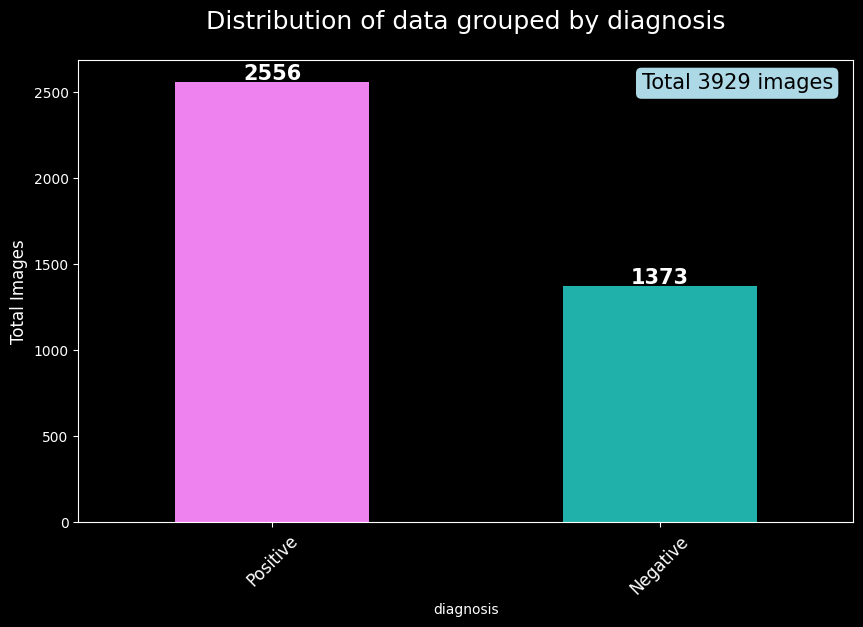

In [17]:
# Plot
ax = df.diagnosis.value_counts().plot(kind='bar',
                                      stacked=True,
                                      figsize=(10, 6),
                                     color=["violet", "lightseagreen"])


ax.set_xticklabels(["Positive", "Negative"], rotation=45, fontsize=12);
ax.set_ylabel('Total Images', fontsize = 12)
ax.set_title("Distribution of data grouped by diagnosis",fontsize = 18, y=1.05)

# Annotate
for i, rows in enumerate(df.diagnosis.value_counts().values):
    ax.annotate(int(rows), xy=(i, rows-12),
                rotation=0, color="white",
                ha="center", verticalalignment='bottom',
                fontsize=15, fontweight="bold")

ax.text(1.2, 2550, f"Total {len(df)} images", size=15,
        color="black",
         ha="center", va="center",
         bbox=dict(boxstyle="round",
                   fc=("lightblue"),
                   ec=("black"),
                   )
         );

Distribution of positive/negative diagnosis between each patient

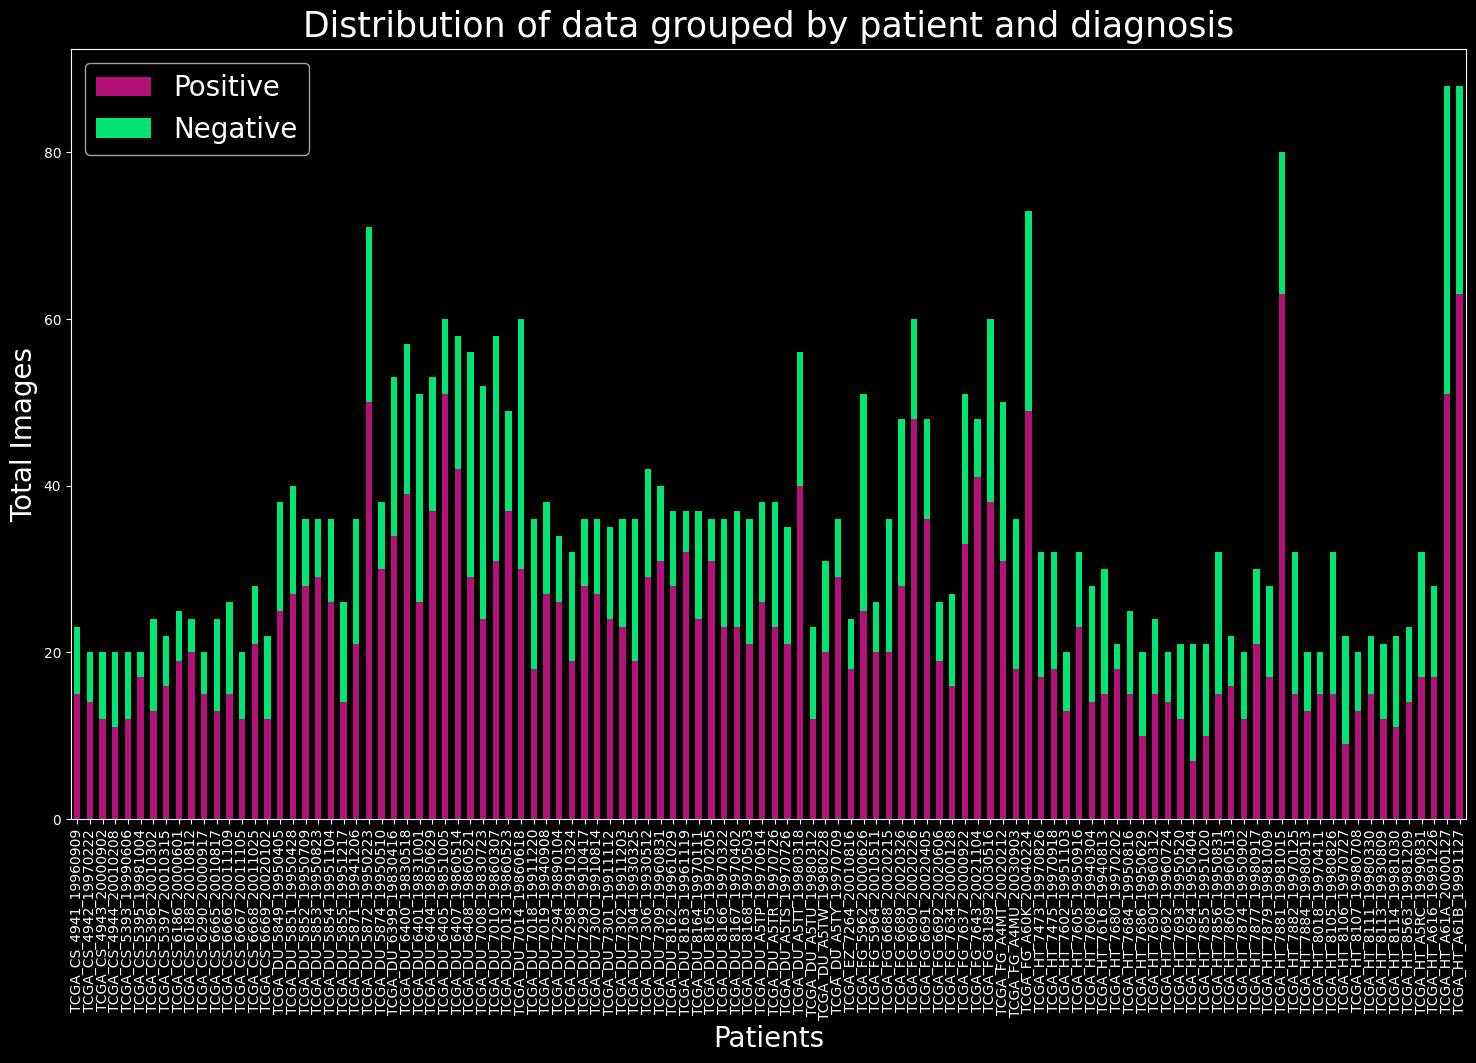

In [18]:
# Data
patients_by_diagnosis = df.groupby(['patient', 'diagnosis'])['diagnosis'].size().unstack().fillna(0)
patients_by_diagnosis.columns = ["Positive", "Negative"]

# Plot
ax = patients_by_diagnosis.plot(kind='bar',stacked=True,
                                figsize=(18, 10),
                                color=["mediumvioletred", "springgreen"],
                                alpha=0.9)
ax.legend(fontsize=20);
ax.set_xlabel('Patients',fontsize = 20)
ax.set_ylabel('Total Images', fontsize = 20)
ax.set_title("Distribution of data grouped by patient and diagnosis",fontsize = 25, y=1.005)

# Annotations
"""for i, rows in enumerate(patients_by_diagnosis.values):
    plt.annotate(int(rows[0]), xy=(i, rows[0]+1), rotation=90, color="white")
    plt.annotate(int(rows[1]), xy=(i, rows[1]+1), rotation=90, color="aqua")""";

## Data Visualization

Samples of images with a positive and negative diagnosis

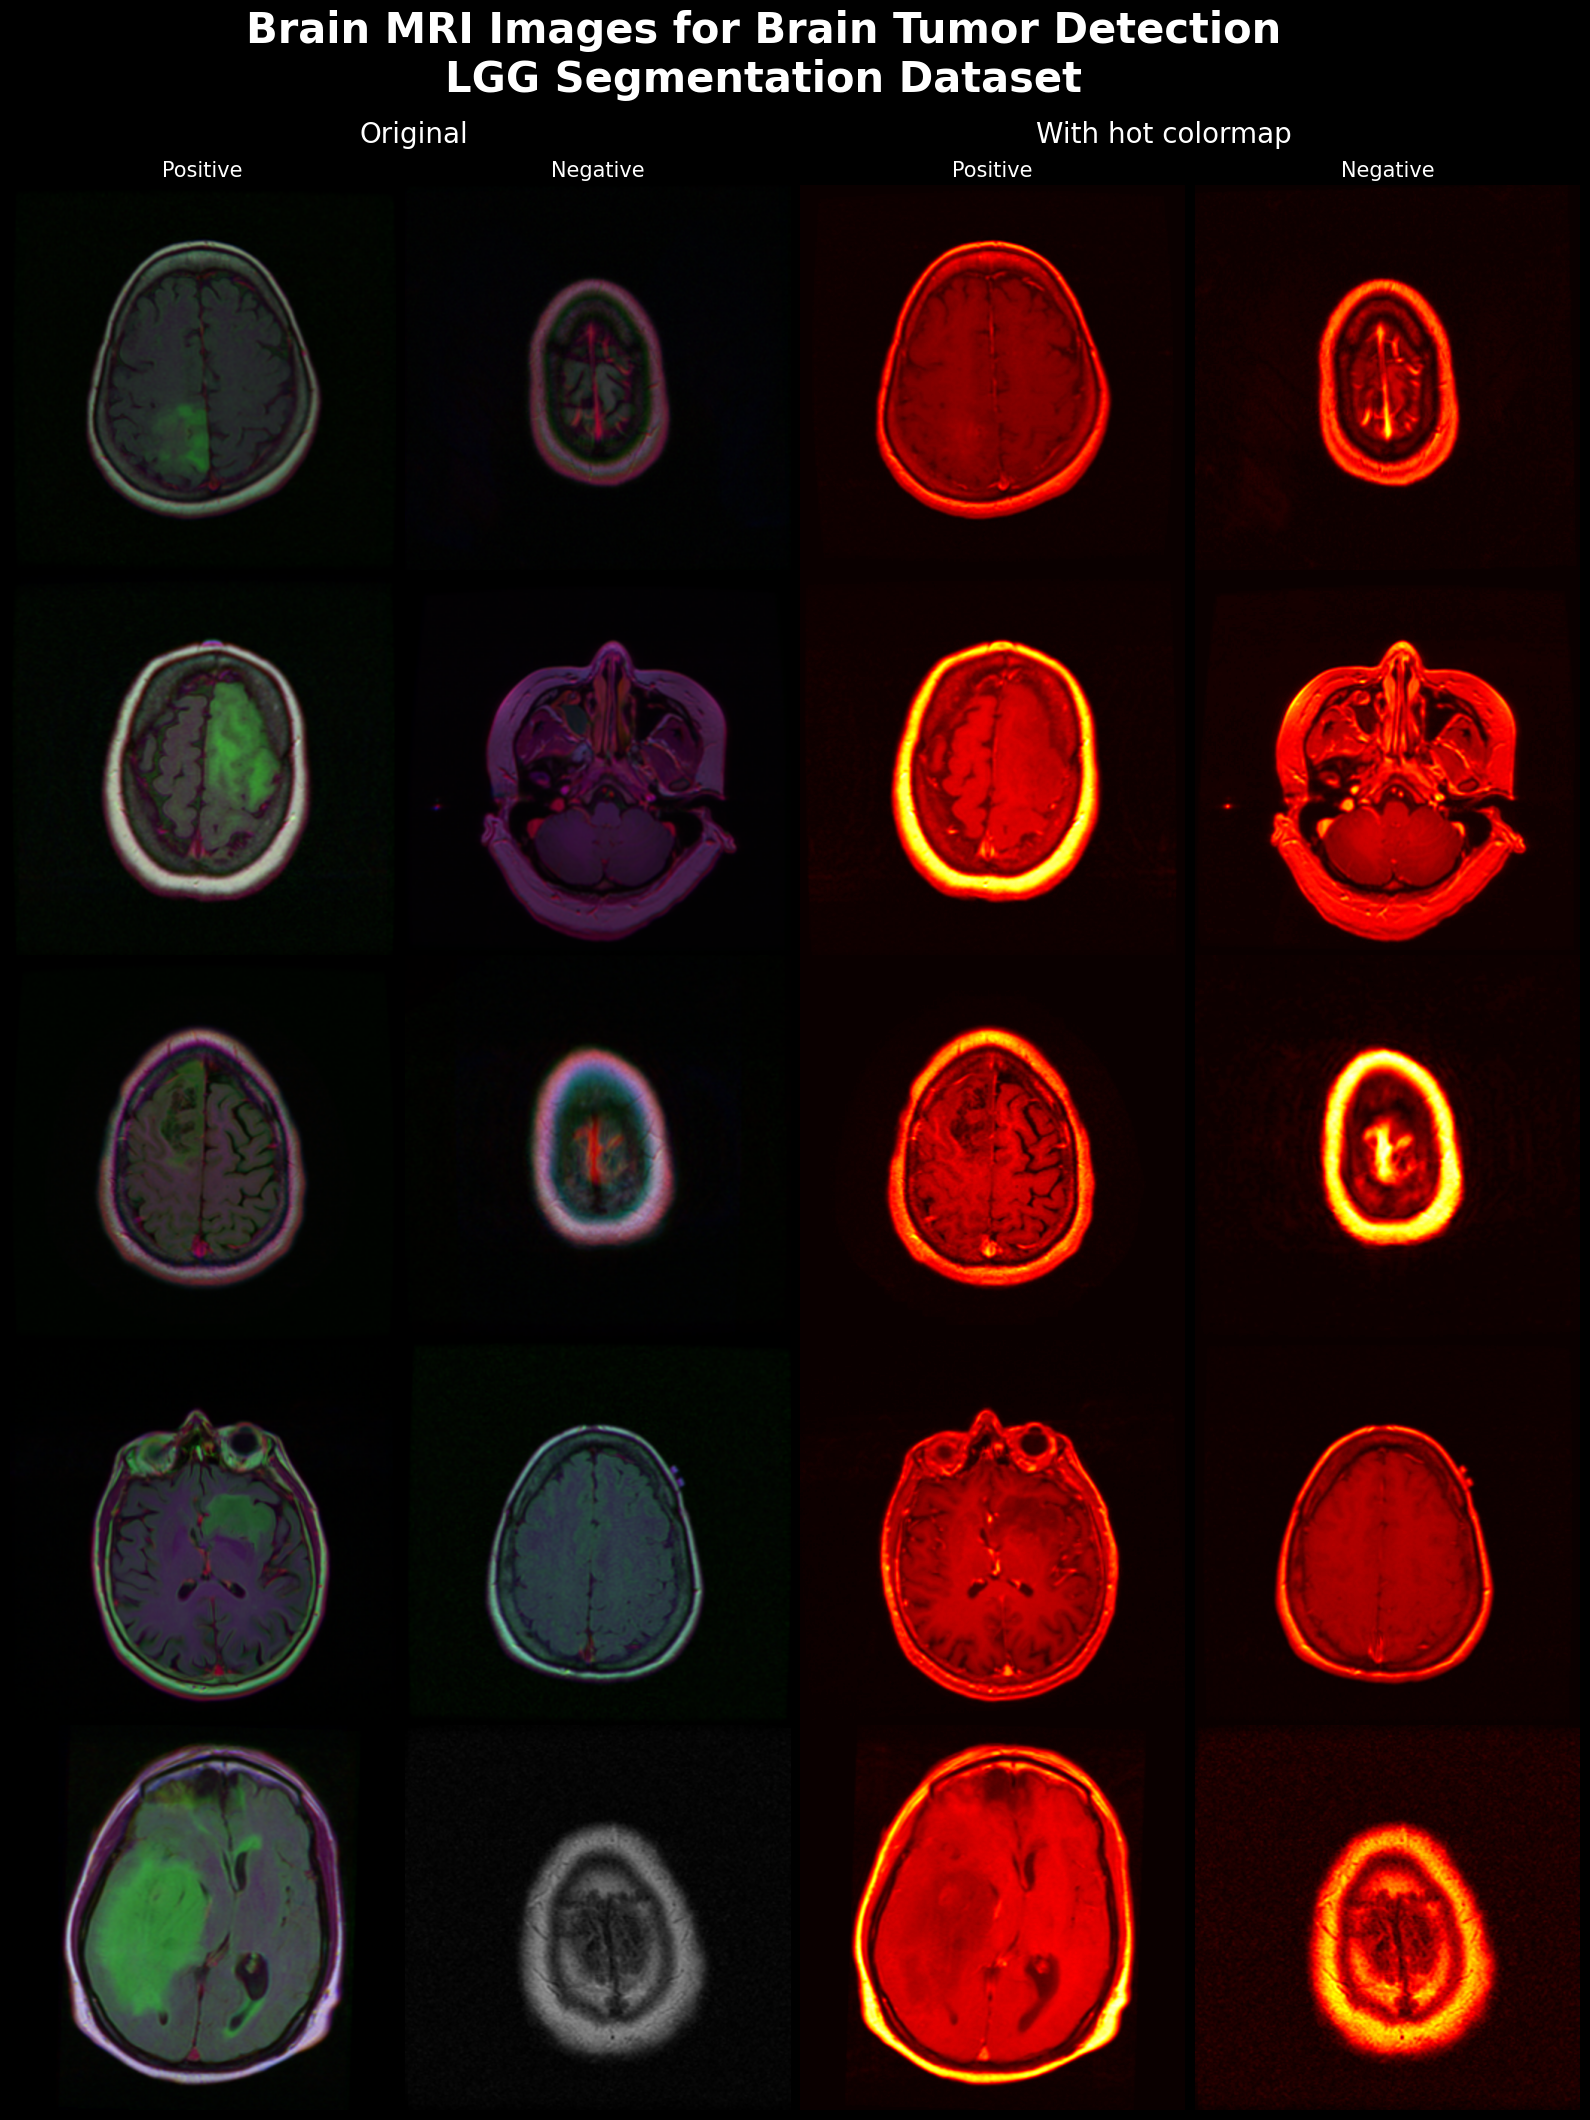

In [19]:
# Data
sample_yes_df = df[df["diagnosis"] == 1].sample(5).image_path.values
sample_no_df = df[df["diagnosis"] == 0].sample(5).image_path.values

sample_imgs = []
for i, (yes, no) in enumerate(zip(sample_yes_df, sample_no_df)):
    yes = cv2.resize(cv2.imread(yes), (IMG_SIZE, IMG_SIZE))
    no = cv2.resize(cv2.imread(no), (IMG_SIZE, IMG_SIZE))
    sample_imgs.extend([yes, no])


sample_yes_arr = np.vstack(np.array(sample_imgs[::2]))
sample_no_arr = np.vstack(np.array(sample_imgs[1::2]))

# Plot
fig = plt.figure(figsize=(25., 25.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(1, 4),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )


grid[0].imshow(sample_yes_arr)
grid[0].set_title("Positive", fontsize=15)
grid[0].axis("off")
grid[1].imshow(sample_no_arr)
grid[1].set_title("Negative", fontsize=15)
grid[1].axis("off")

grid[2].imshow(sample_yes_arr[:,:,0], cmap="hot")
grid[2].set_title("Positive", fontsize=15)
grid[2].axis("off")
grid[3].imshow(sample_no_arr[:,:,0], cmap="hot")
grid[3].set_title("Negative", fontsize=15)
grid[3].axis("off")#set_title("No", fontsize=15)

# annotations
plt.figtext(0.36,0.90,"Original", va="center", ha="center", size=20)
plt.figtext(0.66,0.90,"With hot colormap", va="center", ha="center", size=20)
plt.suptitle("Brain MRI Images for Brain Tumor Detection\nLGG Segmentation Dataset", y=.95, fontsize=30, weight="bold")

# save and show
plt.savefig("dataset.png", bbox_inches='tight', pad_inches=0.2, transparent=True)
plt.show()

Samples of images and masks with a positive diagnosis

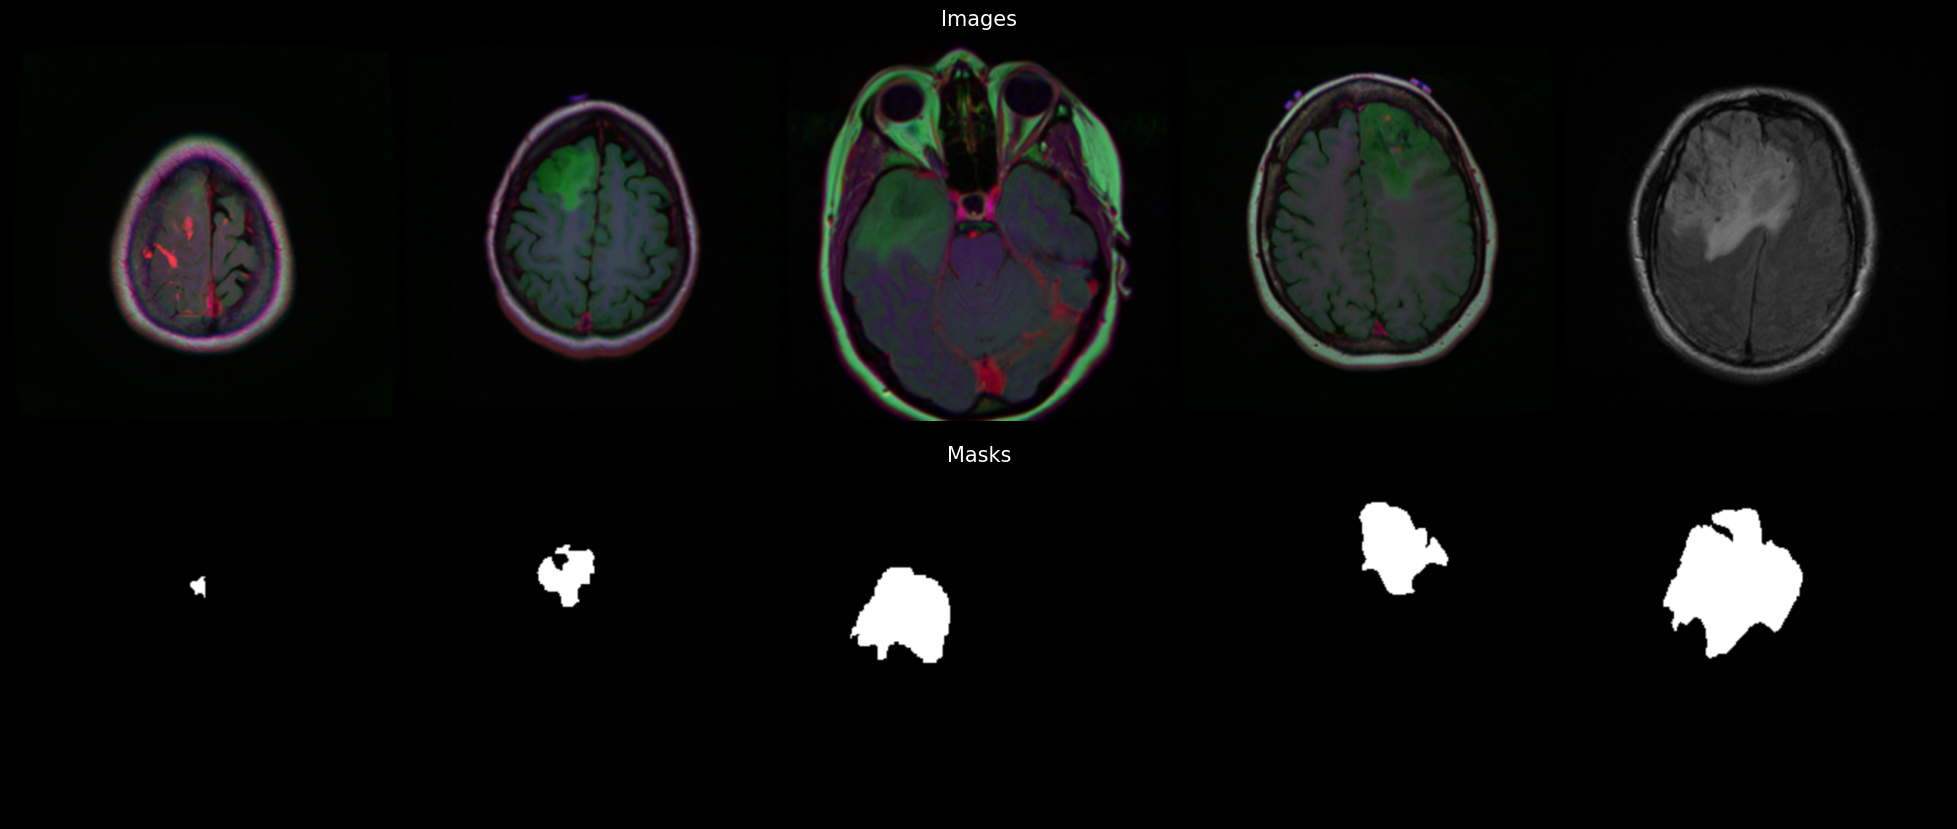

In [20]:
# Data
sample_df = df[df["diagnosis"] == 1].sample(5).values
sample_imgs = []
for i, data in enumerate(sample_df):
    #print(data)
    img = cv2.resize(cv2.imread(data[2]), (IMG_SIZE, IMG_SIZE))
    mask = cv2.resize(cv2.imread(data[3]), (IMG_SIZE, IMG_SIZE))
    sample_imgs.extend([img, mask])


sample_imgs_arr = np.hstack(np.array(sample_imgs[::2]))
sample_masks_arr = np.hstack(np.array(sample_imgs[1::2]))

# Plot
fig = plt.figure(figsize=(25., 25.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(2, 1),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )


grid[0].imshow(sample_imgs_arr)
grid[0].set_title("Images", fontsize=15)
grid[0].axis("off")
grid[1].imshow(sample_masks_arr)
grid[1].set_title("Masks", fontsize=15, y=0.9)
grid[1].axis("off")
plt.show()

# DataGenerator and Data Augmentation

In [21]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import albumentations as A
from albumentations.pytorch import ToTensor, ToTensorV2

from sklearn.model_selection import train_test_split

In [22]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

DataGenerator

In [23]:
class BrainMriDataset(Dataset):
    def __init__(self, df, transforms):

        self.df = df
        self.transforms = transforms

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        image = cv2.imread(self.df.iloc[idx, 2])
        mask = cv2.imread(self.df.iloc[idx, 3], 0)

        augmented = self.transforms(image=image,
                                    mask=mask)

        image = augmented['image']
        mask = augmented['mask']

        return image, mask

        # unnormilize mask
        #mask = torch.clamp(mask.float(), min=0, max=1)
        #mask = torch.ceil(mask)

transforms

In [24]:
PATCH_SIZE = 64#256

strong_transforms = A.Compose([
    A.RandomResizedCrop(width = PATCH_SIZE, height = PATCH_SIZE, p=1.0),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.Transpose(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.01, scale_limit=0.04, rotate_limit=0, p=0.25),

    # Pixels
    A.RandomBrightnessContrast(p=0.5),
    A.RandomGamma(p=0.25),
    A.IAAEmboss(p=0.25),
    A.Blur(p=0.01, blur_limit = 3),

    # Affine
    A.OneOf([
        A.ElasticTransform(p=0.5, alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03),
        A.GridDistortion(p=0.5),
        A.OpticalDistortion(p=1, distort_limit=2, shift_limit=0.5)
    ], p=0.8),


    A.Normalize(p=1.0),
    #https://albumentations.readthedocs.io/en/latest/api/pytorch.html?highlight=ToTensor#albumentations.pytorch.transforms.ToTensor
    ToTensor(),
])


transforms = A.Compose([
    A.Resize(width = PATCH_SIZE, height = PATCH_SIZE, p=1.0),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.Transpose(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.01, scale_limit=0.04, rotate_limit=0, p=0.25),



    A.Normalize(p=1.0),
    ToTensor(),
])

Split data on train val test

In [25]:
# Split df into train_df and val_df
train_df, val_df = train_test_split(df, stratify=df.diagnosis, test_size=0.1)
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)

# Split train_df into train_df and test_df
train_df, test_df = train_test_split(train_df, stratify=train_df.diagnosis, test_size=0.15)
train_df = train_df.reset_index(drop=True)

#train_df = train_df[:1000]
print(f"Train: {train_df.shape} \nVal: {val_df.shape} \nTest: {test_df.shape}")

Train: (3005, 5) 
Val: (393, 5) 
Test: (531, 5)


In [26]:
# train
train_dataset = BrainMriDataset(df=train_df, transforms=transforms)
train_dataloader = DataLoader(train_dataset, batch_size=26, num_workers=4, shuffle=True)

# val
val_dataset = BrainMriDataset(df=val_df, transforms=transforms)
val_dataloader = DataLoader(val_dataset, batch_size=26, num_workers=4, shuffle=True)

#test
test_dataset = BrainMriDataset(df=test_df, transforms=transforms)
test_dataloader = DataLoader(test_dataset, batch_size=26, num_workers=4, shuffle=True)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Augmentation Visualization

torch.Size([26, 3, 64, 64]) torch.Size([26, 1, 64, 64])


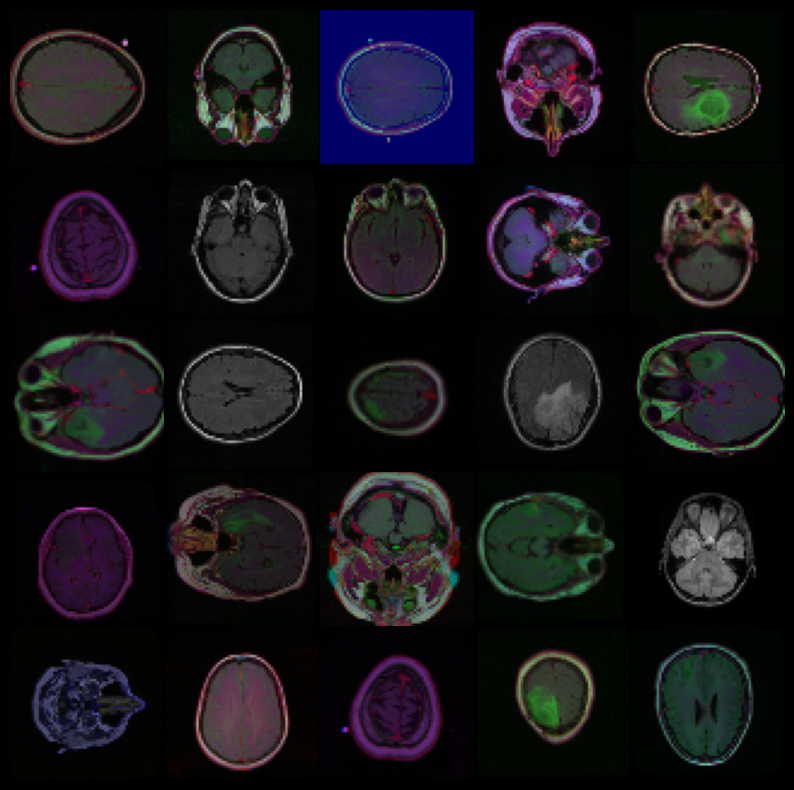

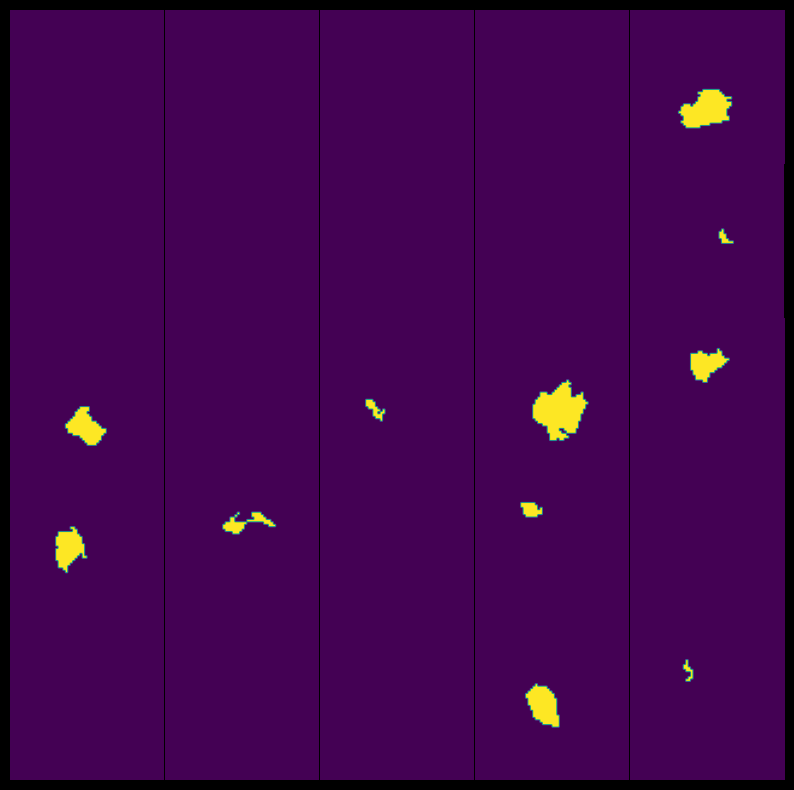

In [27]:
def show_aug(inputs, nrows=5, ncols=5, image=True):
    plt.figure(figsize=(10, 10))
    plt.subplots_adjust(wspace=0., hspace=0.)
    i_ = 0

    if len(inputs) > 25:
        inputs = inputs[:25]

    for idx in range(len(inputs)):

        # normalization
        if image is True:
            img = inputs[idx].numpy().transpose(1,2,0)
            mean = [0.485, 0.456, 0.406]
            std = [0.229, 0.224, 0.225]
            img = (img*std+mean).astype(np.float32)
        else:
            img = inputs[idx].numpy().astype(np.float32)
            img = img[0,:,:]

        #plot
        #print(img.max(), len(np.unique(img)))
        plt.subplot(nrows, ncols, i_+1)
        plt.imshow(img);
        plt.axis('off')

        i_ += 1

    return plt.show()


images, masks = next(iter(train_dataloader))
print(images.shape, masks.shape)

show_aug(images)
show_aug(masks, image=False)

# Model Zoo

## Feature Pyramid Network + UNet

# Unet with Attention Mechanism

## MCF attention and resnext

 Multiclassifier fusion can improve model's performance by combining the outputs of multiple classifiers.

1. **Modify the Model to Output Intermediate Features**: First, modify the model to output intermediate features from different layers.

2. **Add Additional Classifiers**: Add additional classifiers that will use these intermediate features.

3. **Combine Classifier Outputs**: Combine the outputs of these classifiers to produce the final output.

In this modified version, I added additional classifiers (`self.classifier1`, `self.classifier2`, `self.classifier3`, and `self.classifier4`) that operate on the intermediate feature maps. These classifier outputs are combined with the main output using bilinear interpolation to match the size. This fusion process aims to leverage information from multiple levels of the feature hierarchy, potentially improving the model's performance.

In [28]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import resnext50_32x4d

class ChannelAttention(nn.Module):
    def __init__(self, in_planes, ratio=16):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveAvgPool2d(1)

        self.fc1 = nn.Conv2d(in_planes, in_planes // 16, 1, bias=False)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Conv2d(in_planes // 16, in_planes, 1, bias=False)

        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = self.fc2(self.relu1(self.fc1(self.avg_pool(x))))
        max_out = self.fc2(self.relu1(self.fc1(self.max_pool(x))))
        out = avg_out + max_out
        return self.sigmoid(out)

class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()
        assert kernel_size in (3, 7), 'kernel size must be 3 or 7'
        padding = 3 if kernel_size == 7 else 1

        self.conv1 = nn.Conv2d(2, 1, kernel_size, padding=padding, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x = torch.cat([avg_out, max_out], dim=1)
        x = self.conv1(x)
        return self.sigmoid(x)

class DualAttentionModule(nn.Module):
    def __init__(self, in_channels):
        super(DualAttentionModule, self).__init__()
        self.channel_attention = ChannelAttention(in_channels)
        self.spatial_attention = SpatialAttention()

    def forward(self, x):
        x_out = self.channel_attention(x) * x
        x_out = self.spatial_attention(x_out) * x_out
        return x_out

class ConvRelu(nn.Module):
    def __init__(self, in_channels, out_channels, kernel, padding):
        super().__init__()
        self.convrelu = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel, padding=padding),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(out_channels)
        )

    def forward(self, x):
        return self.convrelu(x)

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, dilation_rates):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=dilation_rates[0], dilation=dilation_rates[0])
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=dilation_rates[1], dilation=dilation_rates[1])
        self.conv3 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=dilation_rates[2], dilation=dilation_rates[2])
        self.relu = nn.ReLU(inplace=True)
        self.dam = DualAttentionModule(out_channels)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.bn3 = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        residual = x
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.relu(self.bn2(self.conv2(out)))
        out = self.relu(self.bn3(self.conv3(out)))
        out = self.dam(out)
        out += residual
        return out

class DecoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.conv1 = ConvRelu(in_channels, in_channels // 4, 1, 0)
        self.deconv = nn.ConvTranspose2d(in_channels // 4, in_channels // 4, kernel_size=4, stride=2, padding=1, output_padding=0)
        self.conv2 = ConvRelu(in_channels // 4, out_channels, 1, 0)
        self.residual_block = ResidualBlock(out_channels, out_channels, [1, 2, 5])

    def forward(self, x):
        x = self.conv1(x)
        x = self.deconv(x)
        x = self.conv2(x)
        x = self.residual_block(x)
        return x

class D2AResNeXtUNet(nn.Module):
    def __init__(self, n_classes):
        super().__init__()

        self.base_model = resnext50_32x4d(pretrained=True)
        self.base_layers = list(self.base_model.children())
        filters = [4*64, 4*128, 4*256, 4*512]

        # Down
        self.encoder0 = nn.Sequential(*self.base_layers[:3])
        self.encoder1 = nn.Sequential(*self.base_layers[4])
        self.encoder2 = nn.Sequential(*self.base_layers[5])
        self.encoder3 = nn.Sequential(*self.base_layers[6])
        self.encoder4 = nn.Sequential(*self.base_layers[7])

        # Up
        self.decoder4 = DecoderBlock(filters[3], filters[2])
        self.decoder3 = DecoderBlock(filters[2], filters[1])
        self.decoder2 = DecoderBlock(filters[1], filters[0])
        self.decoder1 = DecoderBlock(filters[0], filters[0])

        # Final Classifiers
        self.last_conv0 = ConvRelu(256, 128, 3, 1)
        self.last_conv1 = nn.Conv2d(128, n_classes, 3, padding=1)

        # Additional Classifiers for Fusion
        self.classifier1 = nn.Conv2d(filters[3], n_classes, 1)
        self.classifier2 = nn.Conv2d(filters[2], n_classes, 1)
        self.classifier3 = nn.Conv2d(filters[1], n_classes, 1)
        self.classifier4 = nn.Conv2d(filters[0], n_classes, 1)

    def forward(self, x):
        # Down
        e0 = self.encoder0(x)
        e1 = self.encoder1(e0)
        e2 = self.encoder2(e1)
        e3 = self.encoder3(e2)
        e4 = self.encoder4(e3)

        # Up + sc
        d4 = self.decoder4(e4) + e3
        d3 = self.decoder3(d4) + e2
        d2 = self.decoder2(d3) + e1
        d1 = self.decoder1(d2)

        # final classifier
        out = self.last_conv0(d1)
        out = self.last_conv1(out)

        # Additional Classifier Outputs for Fusion
        out1 = self.classifier1(e4)
        out2 = self.classifier2(e3)
        out3 = self.classifier3(e2)
        out4 = self.classifier4(e1)

        # Combine Outputs
        out = out + F.interpolate(out1, size=out.shape[2:], mode='bilinear', align_corners=False)
        out = out + F.interpolate(out2, size=out.shape[2:], mode='bilinear', align_corners=False)
        out = out + F.interpolate(out3, size=out.shape[2:], mode='bilinear', align_corners=False)
        out = out + F.interpolate(out4, size=out.shape[2:], mode='bilinear', align_corners=False)

        out = torch.sigmoid(out)

        return out

# Initialize and test the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
rx50 = D2AResNeXtUNet(n_classes=1).to(device)
output = rx50(torch.randn(1, 3, 256, 256).to(device))
print(output.shape)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNeXt50_32X4D_Weights.IMAGENET1K_V1`. You can also use `weights=ResNeXt50_32X4D_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnext50_32x4d-7cdf4587.pth" to /root/.cache/torch/hub/checkpoints/resnext50_32x4d-7cdf4587.pth
100%|██████████| 95.8M/95.8M [00:01<00:00, 71.5MB/s]
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudn

torch.Size([1, 1, 256, 256])


## Unet with ResNeXt50 backbone.

In [ ]:
# from torchvision.models import resnext50_32x4d

# class ConvRelu(nn.Module):
#     def __init__(self, in_channels, out_channels, kernel, padding):
#         super().__init__()

#         self.convrelu = nn.Sequential(
#             nn.Conv2d(in_channels, out_channels, kernel, padding=padding),
#             nn.ReLU(inplace=True)
#         )

#     def forward(self, x):
#         x = self.convrelu(x)
#         return x

# class DecoderBlock(nn.Module):
#     def __init__(self, in_channels, out_channels):
#         super().__init__()

#         self.conv1 = ConvRelu(in_channels, in_channels // 4, 1, 0)

#         self.deconv = nn.ConvTranspose2d(in_channels // 4, in_channels // 4, kernel_size=4,
#                                           stride=2, padding=1, output_padding=0)

#         self.conv2 = ConvRelu(in_channels // 4, out_channels, 1, 0)

#     def forward(self, x):
#         x = self.conv1(x)
#         x = self.deconv(x)
#         x = self.conv2(x)

#         return x

In [ ]:
# class ResNeXtUNet(nn.Module):

#     def __init__(self, n_classes):
#         super().__init__()

#         self.base_model = resnext50_32x4d(pretrained=False)
#         self.base_layers = list(self.base_model.children())
#         filters = [4*64, 4*128, 4*256, 4*512]

#         # Down
#         self.encoder0 = nn.Sequential(*self.base_layers[:3])
#         self.encoder1 = nn.Sequential(*self.base_layers[4])
#         self.encoder2 = nn.Sequential(*self.base_layers[5])
#         self.encoder3 = nn.Sequential(*self.base_layers[6])
#         self.encoder4 = nn.Sequential(*self.base_layers[7])

#         # Up
#         self.decoder4 = DecoderBlock(filters[3], filters[2])
#         self.decoder3 = DecoderBlock(filters[2], filters[1])
#         self.decoder2 = DecoderBlock(filters[1], filters[0])
#         self.decoder1 = DecoderBlock(filters[0], filters[0])

#         # Final Classifier
#         self.last_conv0 = ConvRelu(256, 128, 3, 1)
#         self.last_conv1 = nn.Conv2d(128, n_classes, 3, padding=1)


#     def forward(self, x):
#         # Down
#         x = self.encoder0(x)
#         e1 = self.encoder1(x)
#         e2 = self.encoder2(e1)
#         e3 = self.encoder3(e2)
#         e4 = self.encoder4(e3)

#         # Up + sc
#         d4 = self.decoder4(e4) + e3
#         d3 = self.decoder3(d4) + e2
#         d2 = self.decoder2(d3) + e1
#         d1 = self.decoder1(d2)
#         #print(d1.shape)

#         # final classifier
#         out = self.last_conv0(d1)
#         out = self.last_conv1(out)
#         out = torch.sigmoid(out)

#         return out

In [ ]:
# rx50 = ResNeXtUNet(n_classes=1).to(device)
# output = rx50(torch.randn(1,3,256,256).to(device))
# print(output.shape)

#### Try2

In [ ]:
# import torch
# import torch.nn as nn
# import torch.nn.functional as F
# from torchvision.models import resnext50_32x4d

# class ChannelAttention(nn.Module):
#     def __init__(self, in_planes, ratio=16):
#         super(ChannelAttention, self).__init__()
#         self.avg_pool = nn.AdaptiveAvgPool2d(1)
#         self.max_pool = nn.AdaptiveAvgPool2d(1)

#         self.fc1 = nn.Conv2d(in_planes, in_planes // 16, 1, bias=False)
#         self.relu1 = nn.ReLU()
#         self.fc2 = nn.Conv2d(in_planes // 16, in_planes, 1, bias=False)

#         self.sigmoid = nn.Sigmoid()

#     def forward(self, x):
#         avg_out = self.fc2(self.relu1(self.fc1(self.avg_pool(x))))
#         max_out = self.fc2(self.relu1(self.fc1(self.max_pool(x))))
#         out = avg_out + max_out
#         return self.sigmoid(out)

# class SpatialAttention(nn.Module):
#     def __init__(self, kernel_size=7):
#         super(SpatialAttention, self).__init__()
#         assert kernel_size in (3, 7), 'kernel size must be 3 or 7'
#         padding = 3 if kernel_size == 7 else 1

#         self.conv1 = nn.Conv2d(2, 1, kernel_size, padding=padding, bias=False)
#         self.sigmoid = nn.Sigmoid()

#     def forward(self, x):
#         avg_out = torch.mean(x, dim=1, keepdim=True)
#         max_out, _ = torch.max(x, dim=1, keepdim=True)
#         x = torch.cat([avg_out, max_out], dim=1)
#         x = self.conv1(x)
#         return self.sigmoid(x)

# class DualAttentionModule(nn.Module):
#     def __init__(self, in_channels):
#         super(DualAttentionModule, self).__init__()
#         self.channel_attention = ChannelAttention(in_channels)
#         self.spatial_attention = SpatialAttention()

#     def forward(self, x):
#         x_out = self.channel_attention(x) * x
#         x_out = self.spatial_attention(x_out) * x_out
#         return x_out

# class ConvRelu(nn.Module):
#     def __init__(self, in_channels, out_channels, kernel, padding):
#         super().__init__()
#         self.convrelu = nn.Sequential(
#             nn.Conv2d(in_channels, out_channels, kernel, padding=padding),
#             nn.ReLU(inplace=True),
#             nn.BatchNorm2d(out_channels)
#         )

#     def forward(self, x):
#         return self.convrelu(x)

# class ResidualBlock(nn.Module):
#     def __init__(self, in_channels, out_channels, dilation_rates):
#         super(ResidualBlock, self).__init__()
#         self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=dilation_rates[0], dilation=dilation_rates[0])
#         self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=dilation_rates[1], dilation=dilation_rates[1])
#         self.conv3 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=dilation_rates[2], dilation=dilation_rates[2])
#         self.relu = nn.ReLU(inplace=True)
#         self.dam = DualAttentionModule(out_channels)
#         self.bn1 = nn.BatchNorm2d(out_channels)
#         self.bn2 = nn.BatchNorm2d(out_channels)
#         self.bn3 = nn.BatchNorm2d(out_channels)

#     def forward(self, x):
#         residual = x
#         out = self.relu(self.bn1(self.conv1(x)))
#         out = self.relu(self.bn2(self.conv2(out)))
#         out = self.relu(self.bn3(self.conv3(out)))
#         out = self.dam(out)
#         out += residual
#         return out

# class DecoderBlock(nn.Module):
#     def __init__(self, in_channels, out_channels):
#         super().__init__()

#         self.conv1 = ConvRelu(in_channels, in_channels // 4, 1, 0)
#         self.deconv = nn.ConvTranspose2d(in_channels // 4, in_channels // 4, kernel_size=4, stride=2, padding=1, output_padding=0)
#         self.conv2 = ConvRelu(in_channels // 4, out_channels, 1, 0)
#         self.residual_block = ResidualBlock(out_channels, out_channels, [1, 2, 5])

#     def forward(self, x):
#         x = self.conv1(x)
#         x = self.deconv(x)
#         x = self.conv2(x)
#         x = self.residual_block(x)
#         return x

# class D2AResNeXtUNet(nn.Module):
#     def __init__(self, n_classes):
#         super().__init__()

#         self.base_model = resnext50_32x4d(pretrained=True)
#         self.base_layers = list(self.base_model.children())
#         filters = [4*64, 4*128, 4*256, 4*512]

#         # Down
#         self.encoder0 = nn.Sequential(*self.base_layers[:3])
#         self.encoder1 = nn.Sequential(*self.base_layers[4])
#         self.encoder2 = nn.Sequential(*self.base_layers[5])
#         self.encoder3 = nn.Sequential(*self.base_layers[6])
#         self.encoder4 = nn.Sequential(*self.base_layers[7])

#         # Up
#         self.decoder4 = DecoderBlock(filters[3], filters[2])
#         self.decoder3 = DecoderBlock(filters[2], filters[1])
#         self.decoder2 = DecoderBlock(filters[1], filters[0])
#         self.decoder1 = DecoderBlock(filters[0], filters[0])

#         # Final Classifier
#         self.last_conv0 = ConvRelu(256, 128, 3, 1)
#         self.last_conv1 = nn.Conv2d(128, n_classes, 3, padding=1)

#     def forward(self, x):
#         # Down
#         e0 = self.encoder0(x)
#         e1 = self.encoder1(e0)
#         e2 = self.encoder2(e1)
#         e3 = self.encoder3(e2)
#         e4 = self.encoder4(e3)

#         # Up + sc
#         d4 = self.decoder4(e4) + e3
#         d3 = self.decoder3(d4) + e2
#         d2 = self.decoder2(d3) + e1
#         d1 = self.decoder1(d2)

#         # final classifier
#         out = self.last_conv0(d1)
#         out = self.last_conv1(out)
#         out = torch.sigmoid(out)

#         return out

# # Initialize and test the model
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# rx50 = D2AResNeXtUNet(n_classes=1).to(device)
# output = rx50(torch.randn(1, 3, 256, 256).to(device))
# print(output.shape)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNeXt50_32X4D_Weights.IMAGENET1K_V1`. You can also use `weights=ResNeXt50_32X4D_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnext50_32x4d-7cdf4587.pth" to /root/.cache/torch/hub/checkpoints/resnext50_32x4d-7cdf4587.pth
100%|██████████| 95.8M/95.8M [00:00<00:00, 134MB/s]
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnn

torch.Size([1, 1, 256, 256])


#### Try1


In [ ]:
# import torch
# import torch.nn as nn
# import torch.nn.functional as F
# from torchvision.models import resnext50_32x4d

# class ChannelAttention(nn.Module):
#     def __init__(self, in_planes, ratio=16):
#         super(ChannelAttention, self).__init__()
#         self.avg_pool = nn.AdaptiveAvgPool2d(1)
#         self.max_pool = nn.AdaptiveMaxPool2d(1)

#         self.fc1 = nn.Conv2d(in_planes, in_planes // 16, 1, bias=False)
#         self.relu1 = nn.ReLU()
#         self.fc2 = nn.Conv2d(in_planes // 16, in_planes, 1, bias=False)

#         self.sigmoid = nn.Sigmoid()

#     def forward(self, x):
#         avg_out = self.fc2(self.relu1(self.fc1(self.avg_pool(x))))
#         max_out = self.fc2(self.relu1(self.fc1(self.max_pool(x))))
#         out = avg_out + max_out
#         return self.sigmoid(out)

# class SpatialAttention(nn.Module):
#     def __init__(self, kernel_size=7):
#         super(SpatialAttention, self).__init__()
#         assert kernel_size in (3, 7), 'kernel size must be 3 or 7'
#         padding = 3 if kernel_size == 7 else 1

#         self.conv1 = nn.Conv2d(2, 1, kernel_size, padding=padding, bias=False)
#         self.sigmoid = nn.Sigmoid()

#     def forward(self, x):
#         avg_out = torch.mean(x, dim=1, keepdim=True)
#         max_out, _ = torch.max(x, dim=1, keepdim=True)
#         x = torch.cat([avg_out, max_out], dim=1)
#         x = self.conv1(x)
#         return self.sigmoid(x)

# class DualAttentionModule(nn.Module):
#     def __init__(self, in_channels):
#         super(DualAttentionModule, self).__init__()
#         self.channel_attention = ChannelAttention(in_channels)
#         self.spatial_attention = SpatialAttention()

#     def forward(self, x):
#         x_out = self.channel_attention(x) * x
#         x_out = self.spatial_attention(x_out) * x_out
#         return x_out

# class ConvRelu(nn.Module):
#     def __init__(self, in_channels, out_channels, kernel, padding):
#         super().__init__()
#         self.convrelu = nn.Sequential(
#             nn.Conv2d(in_channels, out_channels, kernel, padding=padding),
#             nn.ReLU(inplace=True)
#         )

#     def forward(self, x):
#         x = self.convrelu(x)
#         return x

# class ResidualBlock(nn.Module):
#     def __init__(self, in_channels, out_channels, dilation_rates):
#         super(ResidualBlock, self).__init__()
#         self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=dilation_rates[0], dilation=dilation_rates[0])
#         self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=dilation_rates[1], dilation=dilation_rates[1])
#         self.conv3 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=dilation_rates[2], dilation=dilation_rates[2])
#         self.relu = nn.ReLU(inplace=True)
#         self.dam = DualAttentionModule(out_channels)

#     def forward(self, x):
#         residual = x
#         out = self.relu(self.conv1(x))
#         out = self.relu(self.conv2(out))
#         out = self.relu(self.conv3(out))
#         out = self.dam(out)
#         out += residual
#         return out

# class DecoderBlock(nn.Module):
#     def __init__(self, in_channels, out_channels):
#         super().__init__()

#         self.conv1 = ConvRelu(in_channels, in_channels // 4, 1, 0)
#         self.deconv = nn.ConvTranspose2d(in_channels // 4, in_channels // 4, kernel_size=4, stride=2, padding=1, output_padding=0)
#         self.conv2 = ConvRelu(in_channels // 4, out_channels, 1, 0)
#         self.residual_block = ResidualBlock(out_channels, out_channels, [1, 2, 5])

#     def forward(self, x):
#         x = self.conv1(x)
#         x = self.deconv(x)
#         x = self.conv2(x)
#         x = self.residual_block(x)
#         return x

# class D2AResNeXtUNet(nn.Module):
#     def __init__(self, n_classes):
#         super().__init__()

#         self.base_model = resnext50_32x4d(pretrained=True)
#         self.base_layers = list(self.base_model.children())
#         filters = [4*64, 4*128, 4*256, 4*512]

#         # Down
#         self.encoder0 = nn.Sequential(*self.base_layers[:3])
#         self.encoder1 = nn.Sequential(*self.base_layers[4])
#         self.encoder2 = nn.Sequential(*self.base_layers[5])
#         self.encoder3 = nn.Sequential(*self.base_layers[6])
#         self.encoder4 = nn.Sequential(*self.base_layers[7])

#         # Up
#         self.decoder4 = DecoderBlock(filters[3], filters[2])
#         self.decoder3 = DecoderBlock(filters[2], filters[1])
#         self.decoder2 = DecoderBlock(filters[1], filters[0])
#         self.decoder1 = DecoderBlock(filters[0], filters[0])

#         # Final Classifier
#         self.last_conv0 = ConvRelu(256, 128, 3, 1)
#         self.last_conv1 = nn.Conv2d(128, n_classes, 3, padding=1)

#     def forward(self, x):
#         # Down
#         x = self.encoder0(x)
#         e1 = self.encoder1(x)
#         e2 = self.encoder2(e1)
#         e3 = self.encoder3(e2)
#         e4 = self.encoder4(e3)

#         # Up + sc
#         d4 = self.decoder4(e4) + e3
#         d3 = self.decoder3(d4) + e2
#         d2 = self.decoder2(d3) + e1
#         d1 = self.decoder1(d2)

#         # final classifier
#         out = self.last_conv0(d1)
#         out = self.last_conv1(out)
#         out = torch.sigmoid(out)

#         return out

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# rx50 = D2AResNeXtUNet(n_classes=1).to(device)
# output = rx50(torch.randn(1, 3, 256, 256).to(device))
# print(output.shape)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNeXt50_32X4D_Weights.IMAGENET1K_V1`. You can also use `weights=ResNeXt50_32X4D_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnext50_32x4d-7cdf4587.pth" to /root/.cache/torch/hub/checkpoints/resnext50_32x4d-7cdf4587.pth
100%|██████████| 95.8M/95.8M [00:00<00:00, 156MB/s]
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnn

torch.Size([1, 1, 256, 256])


# Segmentation Quality Metric

+ https://www.semanticscholar.org/paper/Comparison-of-Jaccard%2C-Dice%2C-Cosine-Similarity-To-Thada-Jaglan/8575e8beef47bd2880c92f54a749f933db983e56

Intuitive interpretation  |  Formula depending on the type of coefficient
:------------------------:|:-------------------------:
![](https://www.pyimagesearch.com/wp-content/uploads/2016/09/iou_equation.png) | ![](https://d3i71xaburhd42.cloudfront.net/8575e8beef47bd2880c92f54a749f933db983e56/2-Table1-1.png)



In [31]:
def dice_coef_metric(inputs, target):
    intersection = 2.0 * (target * inputs).sum()
    union = target.sum() + inputs.sum()
    if target.sum() == 0 and inputs.sum() == 0:
        return 1.0

    return intersection / union

# Metric check
dice_coef_metric(np.array([0., 0.9]),
                 np.array([0., 1]))

0.9473684210526316

# Segmentation Loss

+ https://medium.com/kaggle-blog/carvana-image-masking-challenge-1st-place-winners-interview-78fcc5c887a8

<p>
    <img src="https://miro.medium.com/max/1400/0*u6iEAiz9smASIhuk" width="450" height="300">
</p>

In [32]:
def dice_coef_loss(inputs, target):
    smooth = 1.0
    intersection = 2.0 * ((target * inputs).sum()) + smooth
    union = target.sum() + inputs.sum() + smooth

    return 1 - (intersection / union)


def bce_dice_loss(inputs, target):
    dicescore = dice_coef_loss(inputs, target)
    bcescore = nn.BCELoss()
    bceloss = bcescore(inputs, target)

    return bceloss + dicescore

# loss check
bce_dice_loss(torch.tensor([0.7, 1., 1.]),
              torch.tensor([1.,1.,1.]))

tensor(0.1637)

# Train Models

In [33]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [49]:
!mkdir -p /content/drive/MyDrive/mcf

In [35]:
import os

def train_model(model_name, model, train_loader, val_loader, train_loss, optimizer, lr_scheduler, num_epochs, save_path='/content/drive/MyDrive/mcf'):

    print(model_name)
    loss_history = []
    train_history = []
    val_history = []

    for epoch in range(num_epochs):
        model_path = os.path.join(save_path, f'{model_name}_epoch:{epoch}.pt')

        # Check if the saved model for the current epoch exists
        if os.path.exists(model_path):
            print(f'Model for epoch {epoch} already exists. Loading model and skipping to the next epoch.')
            model = torch.load(model_path)
            continue

        model.train()  # Enter train mode

        losses = []
        train_iou = []

        if lr_scheduler:
            warmup_factor = 1.0 / 100
            warmup_iters = min(100, len(train_loader) - 1)
            lr_scheduler = warmup_lr_scheduler(optimizer, warmup_iters, warmup_factor)

        for i_step, (data, target) in enumerate(train_loader):
            data = data.to(device)
            target = target.to(device)

            outputs = model(data)

            out_cut = np.copy(outputs.data.cpu().numpy())
            out_cut[np.nonzero(out_cut < 0.5)] = 0.0
            out_cut[np.nonzero(out_cut >= 0.5)] = 1.0

            train_dice = dice_coef_metric(out_cut, target.data.cpu().numpy())

            loss = train_loss(outputs, target)

            losses.append(loss.item())
            train_iou.append(train_dice)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if lr_scheduler:
                lr_scheduler.step()

        val_mean_iou = compute_iou(model, val_loader)

        loss_history.append(np.array(losses).mean())
        train_history.append(np.array(train_iou).mean())
        val_history.append(val_mean_iou)

        print("Epoch [%d]" % (epoch))
        print("Mean loss on train:", np.array(losses).mean(),
              "\nMean DICE on train:", np.array(train_iou).mean(),
              "\nMean DICE on validation:", val_mean_iou)

        torch.save(model, model_path)

    return loss_history, train_history, val_history


In [36]:

def compute_iou(model, loader, threshold=0.5):
    """
    Computes accuracy on the dataset wrapped in a loader

    Returns: accuracy as a float value between 0 and 1
    """
    #model.eval()
    valloss = 0

    with torch.no_grad():

        for i_step, (data, target) in enumerate(loader):

            data = data.to(device)
            target = target.to(device)
            #prediction = model(x_gpu)

            outputs = model(data)
           # print("val_output:", outputs.shape)

            out_cut = np.copy(outputs.data.cpu().numpy())
            out_cut[np.nonzero(out_cut < threshold)] = 0.0
            out_cut[np.nonzero(out_cut >= threshold)] = 1.0

            picloss = dice_coef_metric(out_cut, target.data.cpu().numpy())
            valloss += picloss

        #print("Threshold:  " + str(threshold) + "  Validation DICE score:", valloss / i_step)

    return valloss / i_step

#### Modified for handling overfitting

In [37]:
# Optimizers
# unet_optimizer = torch.optim.Adamax(unet.parameters(), lr=1e-3) ## Main optimizer
# unet_optimizer = torch.optim.Adam(unet.parameters(), lr=5e-4)
# fpn_optimizer = torch.optim.Adamax(fpn.parameters(), lr=1e-3)
rx50_optimizer = torch.optim.Adam(rx50.parameters(), lr=1e-3)
# rx50_optimizer = torch.optim.Adam(rx50.parameters(), lr=5e-4)

# lr_scheduler
def warmup_lr_scheduler(optimizer, warmup_iters, warmup_factor):
    def f(x):
        if x >= warmup_iters:
            return 1
        alpha = float(x) / warmup_iters
        return warmup_factor * (1 - alpha) + alpha

    return torch.optim.lr_scheduler.LambdaLR(optimizer, f)

In [38]:
%%time
num_ep = 20
# Train UNet
# unet_lh, unet_th, unet_vh = train_model("Vanila_UNet", unet, train_dataloader, val_dataloader, bce_dice_loss, unet_optimizer, False, 20)

# Train FPN
#fpn_lh, fpn_th, fpn_vh = train_model("FPN", fpn, train_dataloader, val_dataloader, bce_dice_loss, fpn_optimizer, False, 20)#

# Train ResNeXt50
# rx50_lh, rx50_th, rx50_vh = train_model("ResNeXt50", rx50, train_dataloader, val_dataloader, bce_dice_loss, rx50_optimizer, False, num_ep)
# Train Attention Based
rx50_lh, rx50_th, rx50_vh = train_model("AttentionResNeXt50", rx50, train_dataloader, val_dataloader, bce_dice_loss, rx50_optimizer, False, num_ep)

AttentionResNeXt50


/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch [0]
Mean loss on train: 0.5274143762372691 
Mean DICE on train: 0.5452456314680556 
Mean DICE on validation: 0.7267829431939327
Epoch [1]
Mean loss on train: 0.3171913460667791 
Mean DICE on train: 0.7255975214551283 
Mean DICE on validation: 0.7892984096891915
Epoch [2]
Mean loss on train: 0.2674105552121483 
Mean DICE on train: 0.7689667498832683 
Mean DICE on validation: 0.8158156554410271
Epoch [3]
Mean loss on train: 0.24485191099088768 
Mean DICE on train: 0.7867384902965994 
Mean DICE on validation: 0.7714266469525876
Epoch [4]
Mean loss on train: 0.2508510294017093 
Mean DICE on train: 0.7835825453385541 
Mean DICE on validation: 0.8305324828449893
Epoch [5]
Mean loss on train: 0.23758858217504517 
Mean DICE on train: 0.7931950626208033 
Mean DICE on validation: 0.7860419398208646
Epoch [6]
Mean loss on train: 0.2295445935993359 
Mean DICE on train: 0.8004106841656591 
Mean DICE on validation: 0.823996031678422
Epoch [7]
Mean loss on train: 0.21818145769166536 
Mean DICE 

In [ ]:
# saved model in alicolab03
# torch.save(rx50,'/content/drive/MyDrive/DF/Final/rx50_81Percent_10epoch_withoutfusion.pt')

In [ ]:
# !echo "# Fusion-Project" >> README.md

In [ ]:
# #
# !git init
# !git add README.md
# !git commit -m "first commit"
# !git branch -M main
# !git remote add origin https://github.com/alim98/Fusion-Project.git
# !git push -u origin main

In [ ]:
# rx50_lh, rx50_th, rx50_vh = train_model("AttentionResNeXt50", rx50, train_dataloader, val_dataloader, bce_dice_loss, rx50_optimizer, False, 40)


AttentionResNeXt50
Model for epoch 0 already exists. Loading model and skipping to the next epoch.
Model for epoch 1 already exists. Loading model and skipping to the next epoch.
Model for epoch 2 already exists. Loading model and skipping to the next epoch.
Model for epoch 3 already exists. Loading model and skipping to the next epoch.
Model for epoch 4 already exists. Loading model and skipping to the next epoch.
Model for epoch 5 already exists. Loading model and skipping to the next epoch.
Model for epoch 6 already exists. Loading model and skipping to the next epoch.
Model for epoch 7 already exists. Loading model and skipping to the next epoch.
Model for epoch 8 already exists. Loading model and skipping to the next epoch.
Model for epoch 9 already exists. Loading model and skipping to the next epoch.
Model for epoch 10 already exists. Loading model and skipping to the next epoch.
Model for epoch 11 already exists. Loading model and skipping to the next epoch.
Model for epoch 12 

## Train history

In [ ]:
def plot_model_history(model_name,
                        train_history, val_history,
                        num_epochs):

    x = np.arange(num_epochs)

    fig = plt.figure(figsize=(10, 6))
    plt.plot(x, train_history, label='train dice', lw=3, c="springgreen")
    plt.plot(x, val_history, label='validation dice', lw=3, c="deeppink")

    plt.title(f"{model_name}", fontsize=15)
    plt.legend(fontsize=12)
    plt.xlabel("Epoch", fontsize=15)
    plt.ylabel("DICE", fontsize=15)

    fn = str(int(time.time())) + ".png"
    plt.show()
    #plt.savefig(fn, bbox_inches='tight', pad_inches=0.2)
    #plt.close()


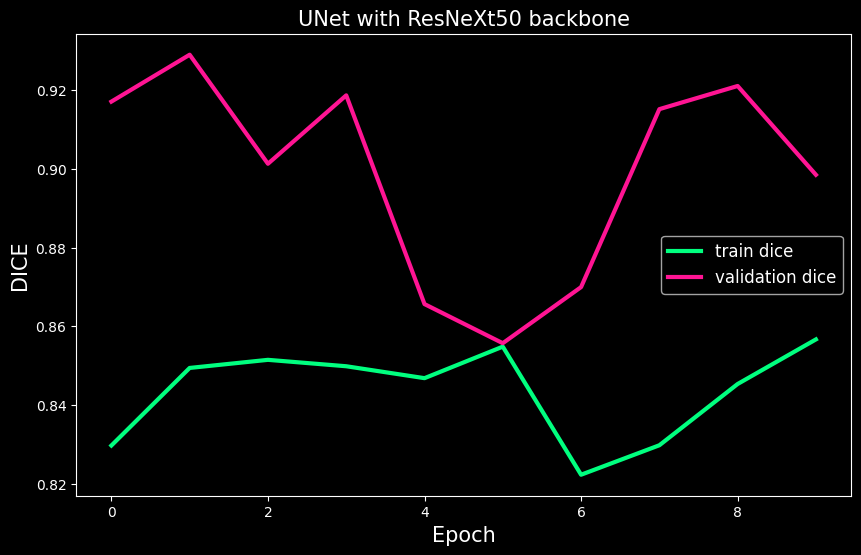

In [ ]:
# plot_model_history("Vanilla UNet", unet_th, unet_vh, 20)
#plot_model_history("FPN", fpn_th, fpn_vh, 20)
plot_model_history("UNet with ResNeXt50 backbone", rx50_th, rx50_vh, 10)

## Test Prediction

### Test IoU

In [39]:
# test_iou = compute_iou(unet, test_dataloader)
# print(f"""Vanilla UNet\nMean IoU of the test images - {np.around(test_iou, 2)*100}%""")

#test_iou = compute_iou(fpn, test_dataloader)
#print(f"""FPN\nMean IoU of the test images - {np.around(test_iou, 2)*100}%""")

test_iou = compute_iou(rx50, test_dataloader)
print(f"""ResNext50\nMean IoU of the test images - {np.around(test_iou, 2)*100}%""")

ResNext50
Mean IoU of the test images - 89.0%


### random test sample

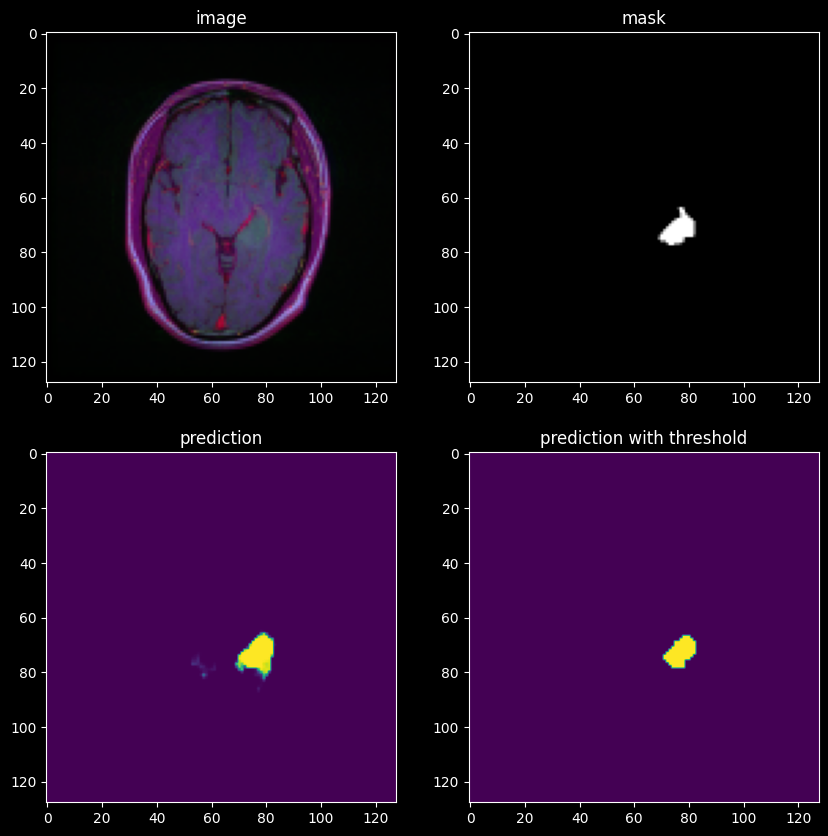

In [40]:
# image
test_sample = test_df[test_df["diagnosis"] == 1].sample(3).values[0]
image = cv2.resize(cv2.imread(test_sample[2]), (128, 128))

#mask
mask = cv2.resize(cv2.imread(test_sample[3]), (128, 128))

# pred
pred = torch.tensor(image.astype(np.float32) / 255.).unsqueeze(0).permute(0,3,1,2)
pred = rx50(pred.to(device)) # change when model changing...........
pred = pred.detach().cpu().numpy()[0,0,:,:]

# pred with tshd
pred_t = np.copy(pred)
pred_t[np.nonzero(pred_t < 0.99)] = 0.0
pred_t[np.nonzero(pred_t >= 0.99)] = 255.#1.0
pred_t = pred_t.astype("uint8")

# plot
fig, ax = plt.subplots(nrows=2,  ncols=2, figsize=(10, 10))

ax[0, 0].imshow(image)
ax[0, 0].set_title("image")
ax[0, 1].imshow(mask)
ax[0, 1].set_title("mask")
ax[1, 0].imshow(pred)
ax[1, 0].set_title("prediction")
ax[1, 1].imshow(pred_t)
ax[1, 1].set_title("prediction with threshold")
plt.show()

### Predictive overlapping on test images

In [41]:
test_samples = test_df[test_df["diagnosis"] == 1].sample(105).values


def batch_preds_overlap(model, samples):
    """
    Computes prediction on the dataset

    Returns: list with images overlapping with predictions

    """
    prediction_overlap = []
    #model.eval():
    for test_sample in samples:

         # sample
        image = cv2.resize(cv2.imread(test_sample[2]),(128, 128))
        image =  image / 255.

        # gt
        ground_truth = cv2.resize(cv2.imread(test_sample[3], 0), (128, 128)).astype("uint8")

        # pred
        prediction = torch.tensor(image).unsqueeze(0).permute(0,3,1,2)
        prediction = model(prediction.to(device).float())
        prediction = prediction.detach().cpu().numpy()[0,0,:,:]

        prediction[np.nonzero(prediction < 0.3)] = 0.0
        prediction[np.nonzero(prediction >= 0.3)] = 255.#1.0
        prediction = prediction.astype("uint8")

        # overlap
        original_img = cv2.resize(cv2.imread(test_sample[2]),(128, 128))

        _, thresh_gt = cv2.threshold(ground_truth, 127, 255, 0)
        _, thresh_p = cv2.threshold(prediction, 127, 255, 0)
        contours_gt, _ = cv2.findContours(thresh_gt, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        contours_p, _ = cv2.findContours(thresh_p, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

        overlap_img = cv2.drawContours(original_img, contours_gt, 0, (0, 255, 0), 1)
        overlap_img = cv2.drawContours(overlap_img, contours_p, 0, (255,36,0), 1)#255,0,0
        prediction_overlap.append(overlap_img)

    return prediction_overlap
 # change when model changing........... # change when model changing........... # change when model changing........... # change when model changing...........

# prediction_overlap_u = batch_preds_overlap(unet, test_samples)
#prediction_overlap_f = batch_preds_overlap(fpn, test_samples)
prediction_overlap_r = batch_preds_overlap(rx50, test_samples)

## Plates of images of predictive overlapping

In [42]:
# DATA
 # change when model changing........... # change when model changing........... # change when model changing........... # change when model changing...........
# unet plates
# pred_overlap_5x1_u = []
# pred_overlap_5x3_u = []

# fpn plates
#pred_overlap_5x1_f = []
#pred_overlap_5x3_f = []

# # rx plates
pred_overlap_5x1_r = []
pred_overlap_5x3_r = []

for i in range(5, 105+5, 5):
    # pred_overlap_5x1_u.append(np.hstack(np.array(prediction_overlap_u[i-5:i])))
    #pred_overlap_5x1_f.append(np.hstack(np.array(prediction_overlap_f[i-5:i])))
    pred_overlap_5x1_r.append(np.hstack(np.array(prediction_overlap_r[i-5:i])))

for i in range(3, 21+3, 3):
  #  pred_overlap_5x3_u.append(np.vstack(pred_overlap_5x1_u[i-3:i]))
   #pred_overlap_5x3_f.append(np.vstack(pred_overlap_5x1_f[i-3:i]))
    pred_overlap_5x3_r.append(np.vstack(pred_overlap_5x1_r[i-3:i]))

In [43]:
# PLOT

def plot_plate_overlap(batch_preds, title, num):
    plt.figure(figsize=(15, 15))
    plt.imshow(batch_preds)
    plt.axis("off")

    plt.figtext(0.76,0.75,"Green - Ground Truth", va="center", ha="center", size=20,color="lime");
    plt.figtext(0.26,0.75,"Red - Prediction", va="center", ha="center", size=20, color="#ff0d00");
    plt.suptitle(title, y=.80, fontsize=20, weight="bold", color="#00FFDE");

    fn = "_".join((title+str(num)).lower().split()) + ".png"
    plt.savefig(fn, bbox_inches='tight', pad_inches=0.2, transparent=False, facecolor='black')
    plt.close()

 # change when model changing........... # change when model changing........... # change when model changing...........

title1 = "Predictions of Vanilla UNet"
title2 = "Predictions of FPN"
title3 = "Predictions of UNet with ResNeXt50 backbone"
 # change when model changing...........
for num, batch in enumerate(pred_overlap_5x3_r):
    plot_plate_overlap(batch,title3, num)


"""for num, (batch1, batch2, batch3) in enumerate(zip(
    pred_overlap_5x3_u, pred_overlap_5x3_f, pred_overlap_5x3_r)):

    plot_plate_overlap(batch1,title1, num)
    plot_plate_overlap(batch2,title2, num)
    plot_plate_overlap(batch3,title3, num)""";

## Gifs

In [44]:
from PIL import Image

def make_gif(title):
    base_name = "_".join(title.lower().split())

    base_len = len(base_name)
    end_len = len(".png")
    fp_in = f"{base_name}*.png"
    fp_out = f"{base_name}.gif"

    img, *imgs = [Image.open(f)
                  for f in sorted(glob.glob(fp_in),
                                  key=lambda x : int(x[base_len:-end_len]))]

    img.save(fp=fp_out, format='GIF', append_images=imgs,
             save_all=True, duration=1000, loop=0)

    return fp_out
 # change when model changing...........

# fn1 = make_gif(title1)
#fn2 = make_gif(title2)
fn3 = make_gif(title3)

### Display gifs


In [45]:
from IPython.display import Image as Image_display

In [46]:
"""with open(fn1,'rb') as f:
    display(Image_display(data=f.read(), format='png'))""";

In [47]:
"""with open(fn3,'rb') as f:
    display(Image_display(data=f.read(), format='png'))""";

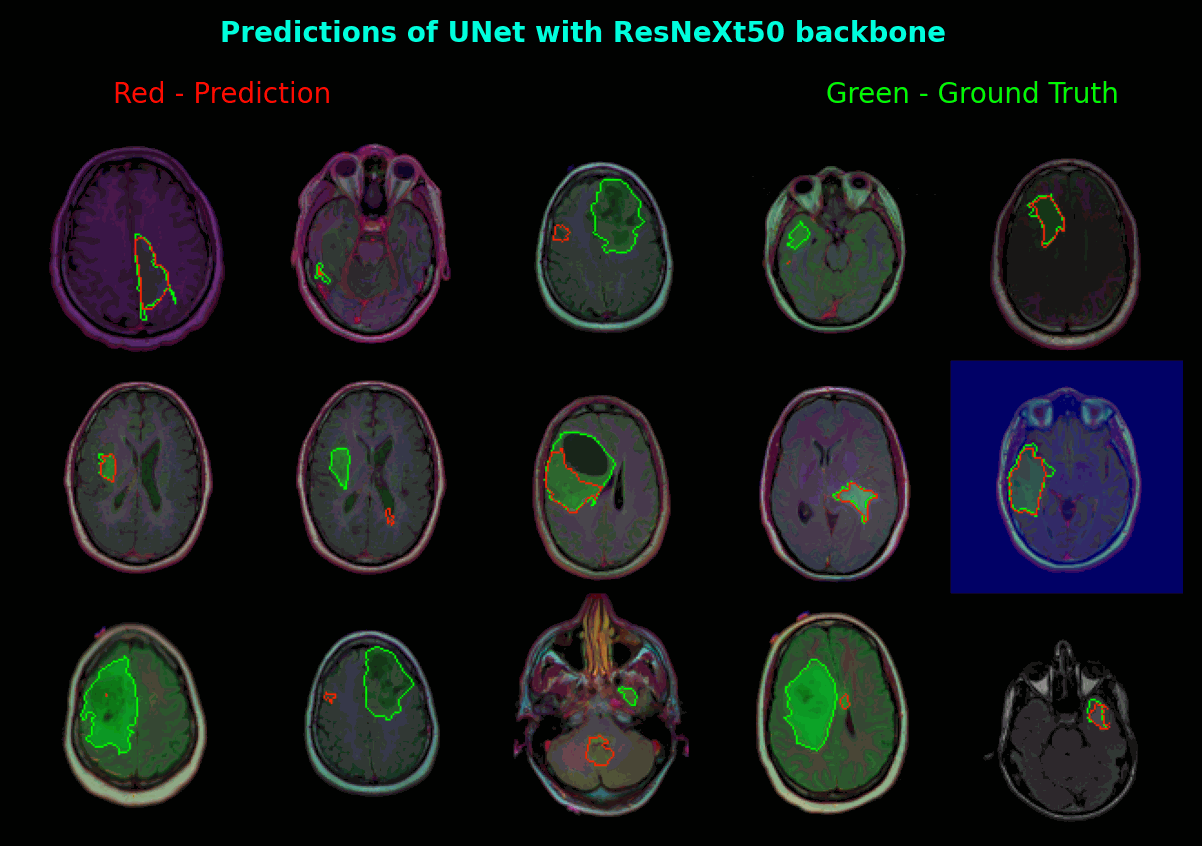

In [48]:
 # change when model changing...........
with open(fn3,'rb') as f:
    display(Image_display(data=f.read(), format='png'))

# What's next?

Experiments:
+  More epochs for training iterations(train longer, without overfitting)
+  Experimenting with different input image size.
+  Experimenting with different batch size.
+  Experimenting with different learning rate.
+  Strong image transforms.
+  Experiments with different UNet backbone
+ Overfits

Fine tuning:
+ Lovasz-Loss
+ lr Schedulers
